# Neutral density

This notebook calculates neutral density ($\gamma$) using the algorithm developed by [Jackett and McDougall 1997](https://doi.org/10.1175/1520-0485(1997)027<0237:ANDVFT>2.0.CO;2).

Before using neutral density, be aware that this is a calculation that uses as a reference a climatology from the World Atlas, Levitus 1980. Therefore, **it shouldn't be used for simulations or datasets with climates/ocean states different to the 1980s (i.e. future projection simulations)**.

We use a python wrapper called `pygamma_n`, developed by Eric Firing and Filipe Fernandes; see https://currents.soest.hawaii.edu/hgstage/pygamma_n.

`pygamma_n` is available from `conda/analysis3-25.06`

In [1]:
import intake

import numpy as np
import xarray as xr
import cf_xarray as cfxr
from joblib import Parallel, delayed

import gsw
import pygamma_n

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

import dask.distributed as dask
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

Initialize a dask client.

In [2]:
client = dask.Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36511,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39869,Total threads: 1
Dashboard: /proxy/44723/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:46067,


Load ACCESS-NRI default catalog and cosima-cookbook default database.

(Note: MOM6 output requires cosima-cookbook to load;
TODO: use intate when MOM6 output become available there)

In [3]:
catalog = intake.cat.access_nri

Define arguments needed to load data from either MOM5 or MOM6.

In [4]:
model_args = {"mom5": {"expt": "01deg_jra55v13_ryf9091",
                       "temperature_variable": "temp",
                       "salinity_variable": "salt",
                       "bathymetry_variable": "ht",
                       "start_time": "2000-01-01",
                       "end_time": "2001-01-01"},

              "mom6": {"expt": "panant-01-zstar-ACCESSyr2",
                       "temperature_variable": "thetao",
                       "salinity_variable": "so",
                       "bathymetry_variable": "deptho",
                       "start_time": "2000-01-01",
                       "end_time": "2001-01-01",
                       "frequency": "1 monthly"}
             }

Define the region to work with:

In [5]:
latitude_slice = slice(-70, -60)
longitude_slice = slice(-70, -40)

We will define a function to load the data needed depending on the model selected. Note that from `mom5` simulations we get conervative temperature (`temp`), whereas from `mom6` we get potential temperature (`thetao`). Both models give us practical salinity, called `salt` and `so` for `mom5` and `mom6` respectively. Also, `mom5` gives us temperature in K! Because neutral density calculation takes in situ temperature, we will use `gsw` to obtain it either model output.

In [6]:
def load_temp_salt(model):
    """
    Loads temperature and salinity variables from the model selected, and does
    the necessary calculations to return in-situ temperature and practical salinity.
    """

    experiment = model_args[model]["expt"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]
    
    T = model_args[model]["temperature_variable"]
    S = model_args[model]["salinity_variable"]

    # Load variables
    data = catalog[experiment].search(variable = [T, S], frequency = "1mon").to_dask(xarray_open_kwargs={"decode_timedelta": True})

    # Ensure we get the time-slice we wanted
    temp = data[T].cf.sel({'time': slice(start_time, end_time)})
    salt = data[S].cf.sel({'time': slice(start_time, end_time)})
    
    # Crop a region (we don't want global/circumpolar data for the sakes of this example)
    temp = temp.cf.sel({'longitude': longitude_slice, 'latitude': latitude_slice})
    salt = salt.cf.sel({'longitude': longitude_slice, 'latitude': latitude_slice})

    # Calculate pressure from the vertical axis and absolute salinity
    pressure = gsw.p_from_z(-salt.cf['vertical'], salt.cf['latitude'].mean())
    absolute_salinity = gsw.SA_from_SP(salt, pressure, salt.cf['longitude'], salt.cf['latitude'])
    
    # Get in-situ temperature and convert to degrees C if needed
    if model == 'mom5':
        conservative_temperature_in_C = temp - 273.15
    elif model == 'mom6':
        conservative_temperature_in_C = gsw.CT_from_pt(absolute_salinity, temp)

    insitu_temp = gsw.t_from_CT(absolute_salinity, conservative_temperature_in_C, pressure).rename('temp')

    return insitu_temp, salt

The `pygamma_n` function to calculate neutral densities takes 2D fields. So for our time-varying, 3D fields we are going to need to iterate twice. We will define a function that calculates $\gamma$ for a certain time step and longitude.

In [7]:
def neutral_density(temp, salt, time_step, longitude):
    """
    Calculates neutral density (gamma) for a given longitude and time 
    of in-situ temperature and practical salinity datasets.
    """
    
    # Select the longitude and time_step
    temp_i = temp.cf.isel({'longitude':longitude, 'time':time_step})
    salt_i = salt.cf.isel({'longitude':longitude, 'time':time_step})
    pressure_i = gsw.p_from_z(-salt_i.cf['vertical'], salt_i.cf['latitude'])
    latitude_i = temp_i.cf['latitude']
    longitude_i = 0 * latitude_i + temp.cf['longitude'][longitude]
    
    gamma, dg_lo, dg_hi = pygamma_n.gamma_n(salt_i.transpose(), temp_i.transpose(), pressure_i.transpose(), 
                                            longitude_i, latitude_i)
    gamma  = gamma.T
    
    return gamma

### Using MOM5 output

Now we are ready. First, let's open some data:

In [8]:
t_mom5, s_mom5 = load_temp_salt('mom5')

And load into memory:

In [9]:
t_mom5 = t_mom5.load()
s_mom5 = s_mom5.load()

We will use `joblib` `delayed` function to calculate the neutral density for a fixed longitude and time step in parallel. Remember that this is because `gamma_n` takes 2D fields.

We first need to create a list of the arguments we are passing to our `neutral_density` function (longitude and time_step):

In [10]:
Nt = len(t_mom5.cf['time'])
Nx = len(t_mom5.cf['longitude'])

args_list = [(i, j) for i in range(Nt) for j in range(Nx)]

Now we can use the `delayed` function:

In [11]:
results = Parallel(n_jobs=-1)(delayed(neutral_density)(t_mom5, s_mom5, arg1, arg2) for arg1, arg2 in args_list)

Now we need to put our results into the correct shape:

In [12]:
gamma_mom5 = np.nan * np.zeros(np.shape(t_mom5))

for idx, result in enumerate(results):
    i, j = divmod(idx, Nx)
    gamma_mom5[i, :, :, j] = result

Make an `xarray.DataArray` complete with dimensions and coordinates, as well as some attributes:

In [13]:
gamma_mom5 = xr.DataArray(gamma_mom5, dims = t_mom5.dims, coords = t_mom5.coords, name = 'gamma')
gamma_mom5.attrs['long_name'] = 'neutral density'
gamma_mom5.attrs['units'] = 'kg/m3'

`pygamma_n.gamman` has a fill value of 0. Let's replace that with nans:

In [14]:
gamma_mom5 = gamma_mom5.where(gamma_mom5 != 0, np.nan)

## Calculating for `mom6`

We can apply the same procedure for `mom6` data:

In [24]:
model = "mom6"
experiment = model_args[model]["expt"]


In [25]:
T = model_args[model]["temperature_variable"]
S = model_args[model]["salinity_variable"]

In [32]:
data = catalog[experiment].search(variable = T, frequency = "1mon")#.to_dask(xarray_open_kwargs={"decode_timedelta": True})


In [15]:
t_mom6, s_mom6 = load_temp_salt('mom6')
t_mom6 = t_mom6.load()
s_mom6 = s_mom6.load()

Nt = len(t_mom6.cf['time'])
Nx = len(t_mom6.cf['longitude'])

args_list = [(i, j) for i in range(Nt) for j in range(Nx)]

results = Parallel(n_jobs=-1)(delayed(neutral_density)(t_mom6, s_mom6, arg1, arg2) for arg1, arg2 in args_list)

gamma_mom6 = np.nan * np.zeros(np.shape(t_mom6))

for idx, result in enumerate(results):
    i, j = divmod(idx, Nx)
    gamma_mom6[i, :, :, j] = result

gamma_mom6 = xr.DataArray(gamma_mom6, dims = t_mom6.dims, coords = t_mom6.coords, name = 'gamma')
gamma_mom6.attrs['long_name'] = 'neutral density'
gamma_mom6.attrs['units'] = 'kg/m3'
gamma_mom6 = gamma_mom6.where(gamma_mom6 != 0, np.nan)

# Plotting

Let's get the model's land mask to plot the time-mean neutral density at a certain depth.

In [18]:
def get_land_mask(model):
    experiment = model_args[model]["expt"]
    bathymetry_variable = model_args[model]["bathymetry_variable"]

    bathymetry = catalog[experiment].search(variable = bathymetry_variable, path=".*output000.*").to_dask()[bathymetry_variable]    
    bathymetry = bathymetry.cf.sel({'longitude': longitude_slice, 'latitude': latitude_slice})
    
    land_mask = xr.where(np.isnan(bathymetry), 1, np.nan)
    land_mask = land_mask.rename('land_mask')
    
    return land_mask

In [19]:
land_mask_mom5 = get_land_mask('mom5')
land_mask_mom6 = get_land_mask('mom6')

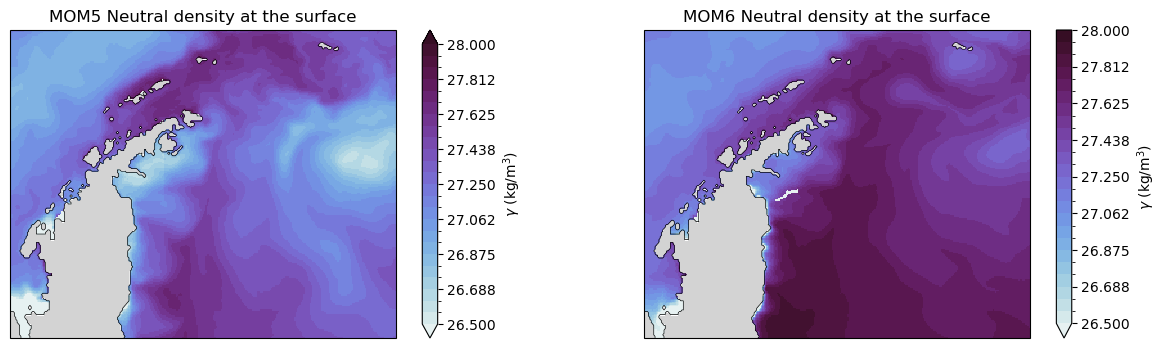

In [20]:
fig = plt.figure(figsize = (15, 4))

projection = ccrs.Mercator(central_longitude = -55)
axs = [fig.add_subplot(121, projection = projection),
       fig.add_subplot(122, projection = projection)]

# Set the region
for ax in axs:
    ax.set_extent([-70, -40, -70, -60], crs = ccrs.PlateCarree())

# Add model land mask
land_mask_mom5.plot.contourf(ax=axs[0], colors='lightgrey', transform=ccrs.PlateCarree(), add_colorbar=False, zorder=2)
land_mask_mom6.plot.contourf(ax=axs[1], colors='lightgrey', transform=ccrs.PlateCarree(), add_colorbar=False, zorder=2)

# Add model coastline
land_mask_mom5.fillna(0).plot.contour(ax=axs[0], colors='k', levels=[0, 1], 
                                      transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5, zorder=3)
land_mask_mom6.fillna(0).plot.contour(ax=axs[1], colors='k', levels=[0, 1], 
                                      transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5, zorder=3)

# Plot time-mean neutral density at the surface
gamma_mom5.cf.mean('time').cf.isel(vertical = 0).plot.pcolormesh(ax=axs[0], cmap = cmocean.cm.dense, transform=ccrs.PlateCarree(),
                                                                 vmin = 26.5, vmax = 28, levels = 25,
                                                                 cbar_kwargs = {'label': '$\\gamma$ (kg/m$^{3}$)'})
gamma_mom6.cf.mean('time').cf.isel(vertical = 0).plot.pcolormesh(ax=axs[1], cmap = cmocean.cm.dense, transform=ccrs.PlateCarree(),
                                                                 vmin = 26.5, vmax = 28, levels = 25,
                                                                 cbar_kwargs = {'label': '$\\gamma$ (kg/m$^{3}$)'})
axs[0].set_title('MOM5 Neutral density at the surface')
axs[1].set_title('MOM6 Neutral density at the surface');

And now let's do a cross section:

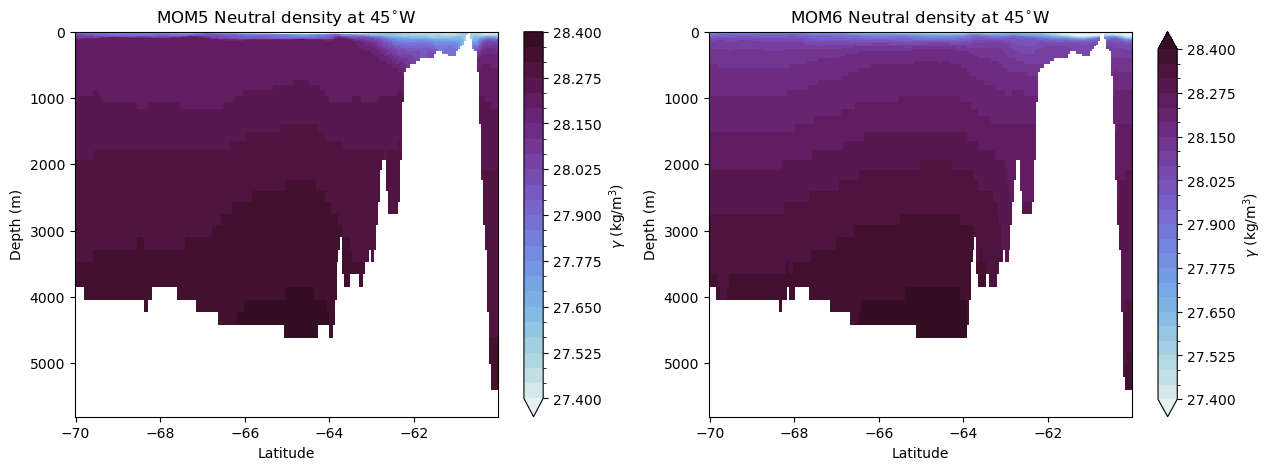

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

gamma_mom5.cf.mean('time').cf.sel(longitude = -45,
                                  method = 'nearest').plot.pcolormesh(ax=axs[0], cmap=cmocean.cm.dense,
                                                                      vmin = 27.4, vmax = 28.4, levels = 25,
                                                                      cbar_kwargs={'label': '$\\gamma$ (kg/m$^{3}$)'})
gamma_mom6.cf.mean('time').cf.sel(longitude = -45,
                                  method = 'nearest').plot.pcolormesh(ax=axs[1], cmap=cmocean.cm.dense,
                                                                      vmin = 27.4, vmax = 28.4, levels = 25,
                                                                      cbar_kwargs={'label': '$\\gamma$ (kg/m$^{3}$)'})

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('Latitude');

axs[0].set_title('MOM5 Neutral density at 45$^{\circ}$W')
axs[1].set_title('MOM6 Neutral density at 45$^{\circ}$W');